# Deep Learning Take Home Assignment 

**1. Harsh Vardhan Singh - 201911022** <br>
**2. Raj Prajapati - 201911029**

In [ ]:
#!unzip "dataset1.zip"
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
import cv2
from os.path import isfile, join
from os import listdir
import string
import re
import nltk

# 1 - CNN architecture with Parallel Inputs

**1. Problem Statement : Multi-input model for image and word tag recognition.** <br>
**2. Dataset : Inspired from kaggle challenge, dataset directly taken from there.** <br>
https://www.kaggle.com/c/challenges-in-representation-learning-multi-modal-learning/data <br>
Note: Entire dataset is too large we have used only 1000 images and word tags for the assignment purpose. <br>

**Problem Description :** <br>
Each image in the dataset is associated with some tags, like an image of a face can be associated with tags like [man,face,eyes,nose,smile etc]. So given an image we need to find out the best suitable tags associated with it. 

**Example Below :** <br>
Image of a car with tags associated to it : <br>
(trees, gray, sedan, lights, wheels, tan, auto, tree, silver, street, tires, wheel, ford, building, grey, palm, brown, vehicle, automobile, beige, window, blue, drive, road).


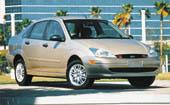
<br>

**Dataset Description** <br>
1000 Images and 1000 tag files (jpeg and desc respectively.)

# Data Preparation

In [ ]:
# Data Map Preparation 
label_path = "/content/data/labels"
thumbnail_path = "/content/data/thumbnails"
label_map = {'label_file' : [], 'word_tags' : []}
for fname in listdir(label_path): 
  f = join(label_path, fname)
  if isfile(f):
    f = open(f)
    label_map['label_file'].append(fname)
    line = f.read().splitlines()
    label_map['word_tags'].append(line)
label_df = pd.DataFrame(label_map)
label_df.head(5)

,label_file,word_tags
0,1c0ac1ef67420c1d2d7d1dc17a63aa44575059c2e2a20a...,"[floor, cloth, under, tablecloth, table, puppy..."
1,e2a0a0f034d55ac2a06922ceeec51a0909af1f66d93f85...,"[guy, male, old, eyes, mustache, boy, beard, k..."
2,5c7d27b0e41de1cbf1748a31b14f906a368ec6ff263553...,"[fun, orange, tube, girl, toy, game, red, camp..."
3,e994396e2cd6955fc313761f5e7e19bae44ca6508f99d0...,"[grammy, man, microphone, award, sunglasses, a..."
4,7c201243f8d9dc836da1bec876c74d819519ee8350b77f...,"[windows, path, door, columns, garden, bushes,..."


In [ ]:
num_of_samples = label_df.shape[0]
num_of_samples

1000

# Model Creation 
1. Model for Text Classification
2. Model for Image Recognition

# Overall Model Architecture
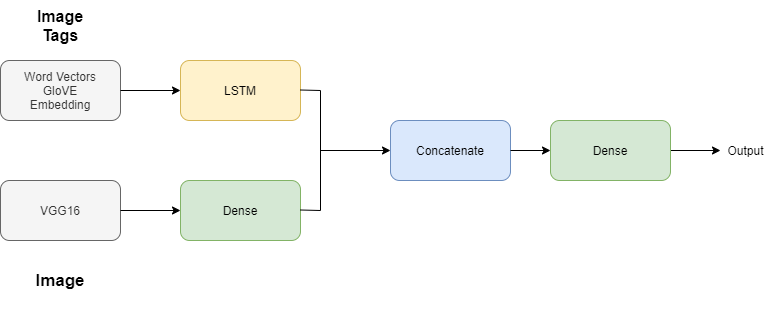

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100
training_samples = num_of_samples
tag_vocabulary_size = 10000
max_words = tag_vocabulary_size

# GloVe: Global Vectors for Word Representation

In [ ]:
glove_dir = '/content'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


# Tokenization and Embedding Matrix




In [ ]:
tokenizer = Tokenizer(num_words=max_words)
texts = []
for tag_list in label_df_clean['word_tags']:
    texts.append(' '.join(tag_list))
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found {} unique tokens'.format(len(word_index)))
tag_data = pad_sequences(sequences, maxlen=maxlen)


embedding_dim = 50
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

Found 2887 unique tokens


# Model Creation 
1. LSTM  
2. CNN (vgg16)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense,Flatten,Concatenate,Input,Embedding,LSTM
from tensorflow.keras import Model


# LSTM part for TEXT 
tag_input = Input(shape=(None,), dtype='int32', name='tag')
embedded_tag = Embedding(max_words, embedding_dim)(tag_input)
encoded_tag = LSTM(512)(embedded_tag)

# CNN part for IMAGE
image_input = Input(shape=(150, 150, 3), name='image')
vgg16 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))(image_input)
x = Flatten()(vgg16) 
x = Dense(256, activation='relu')(x)

concatenated = Concatenate()([x, encoded_tag])
output = Dense(1, activation='sigmoid')(concatenated)
model = Model([image_input, tag_input], output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 4, 4, 512)    14714688    image[0][0]                      
__________________________________________________________________________________________________
tag (InputLayer)                [(None, None)]       0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 8192)         0           vgg16[0][0]                      
_______________________________________________________________________________________

# Freezing Layers and Updating Weights

Embedding layers are freezed because we already have the global vectors for word representation and we have created the embedding matrix.

Note: We can freeze the VGG16 layers also but we have kept them trainable.


In [ ]:
model.layers[4].set_weights([embedding_matrix])
model.layers[4].trainable = False # freeze GloVe word embedding

# Training Data

1. Wrong tag samples are added as noise to the data to create robust model with some random tag for an image.


In [ ]:
dim = (150, 150)
X_image_train = []
X_tag_train = tag_data
y_train = []
    
for fname in listdir(thumbnail_path):
    fpath = os.path.join(thumbnail_path, fname)
    im = cv2.imread(fpath)
    im_resized = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
    X_image_train.append(im_resized)
    y_train.append(1)
  
# add wrong tag samples
num_negative_samples = len(y_train)
for i in range(num_negative_samples):
    image = X_image_train[i]
    X_image_train.append(image)
    j = (i + 1) % num_negative_samples # get a different tag
    tag = X_tag_train[j]
    X_tag_train = np.append(X_tag_train, tag) 
    y_train.append(0)

X_image_train = np.array(X_image_train)
X_tag_train   = np.array(X_tag_train)
y_train       = np.array(y_train)
# Random shuffling of data
perm = np.arange(y_train.shape[0])
np.random.shuffle(perm)
X_image_train = X_image_train[perm]
X_tag_train   = X_tag_train[perm]
y_train       = y_train[perm]
X_image_train.shape, X_tag_train.shape, y_train.shape

((2000, 150, 150, 3), (2000,), (2000,))

In [ ]:
model.fit([X_image_train, X_tag_train], y_train, epochs=30, batch_size=64)

Epoch 1/30
32/32 [==============================] - 12s 367ms/step - loss: 3.6729 - acc: 0.5020
Epoch 2/30
32/32 [==============================] - 12s 367ms/step - loss: 0.7035 - acc: 0.4975
Epoch 3/30
32/32 [==============================] - 12s 371ms/step - loss: 0.6921 - acc: 0.5355
Epoch 4/30
32/32 [==============================] - 12s 372ms/step - loss: 0.6884 - acc: 0.5310
Epoch 5/30
32/32 [==============================] - 12s 364ms/step - loss: 0.6711 - acc: 0.5475
Epoch 6/30
32/32 [==============================] - 11s 359ms/step - loss: 0.6480 - acc: 0.5380
Epoch 7/30
32/32 [==============================] - 11s 359ms/step - loss: 0.6373 - acc: 0.5470
Epoch 8/30
32/32 [==============================] - 12s 362ms/step - loss: 0.6378 - acc: 0.5445
Epoch 9/30
32/32 [==============================] - 12s 365ms/step - loss: 0.6338 - acc: 0.5550
Epoch 10/30
32/32 [==============================] - 12s 366ms/step - loss: 0.6364 - acc: 0.5450
Epoch 11/30
32/32 [====================

# Testing Data

Testing data format consist of three parts:
1. Image
2. Tag1
3. Tag2

For each image you are given two tags, you need to predict the probability score of each tag, whichever tag gets higher score is the most accurate tag for that image.

**Before Testing we need to follow these steps:**
1. Load Testing Data
2. Preprocessing of images and text
3. Tokenization of text

In [ ]:
test_image_dir = '/content/test/public_test_images'
test_label_dir = '/content/test/public_test_options'

# Dictionary Mapping for Testing Data
test_image_label_map = {'image_file' : [], 'label_file_0' : [], 'word_tags_0' : [], 'label_file_1' : [], 'word_tags_1' : []}
for fname in listdir(test_image_dir): 
    test_image_label_map['image_file'].append(fname)
    lfname_base = fname[:-4]
    lfname1 = lfname_base + '.option_0.desc'
    lfname2 = lfname_base + '.option_1.desc'
    lf1 = join(test_label_dir, lfname1)
    lf2 = join(test_label_dir, lfname2)
    if isfile(lf1):
        f1 = open(lf1)
        test_image_label_map['label_file_0'].append(lfname1)
        line = f1.read().splitlines()
        test_image_label_map['word_tags_0'].append(line)
        f1.close()
    else:
        print('invalid file: ' + lfname1)
        
    if isfile(lf2):
        f2 = open(lf2)
        test_image_label_map['label_file_1'].append(lfname2)
        line = f2.read().splitlines()
        test_image_label_map['word_tags_1'].append(line)
        f2.close()
    else:
        print('invalid file: ' + lfname2)

test_image_label_df = pd.DataFrame(test_image_label_map)
test_image_label_df.head(3)

,image_file,label_file_0,word_tags_0,label_file_1,word_tags_1
0,208.png,208.option_0.desc,"[word, ocean, land, directions, islands, scale...",208.option_1.desc,"[duckface, woman, face, naked, black, hair, gr..."
1,197.png,197.option_0.desc,"[word, wall, street, painting, hoodie, sweatja...",197.option_1.desc,"[meal, kids, eat, grass, sandwich, sandwiches,..."
2,101.png,101.option_0.desc,"[face, red, headwrap, woman, tattoo, picture]",101.option_1.desc,"[cooking, grill, grilling, barbecue, hamburger..."


In [ ]:
# Image and Tags Preprocessing for Testing

dim = (150, 150)
X_image_test = []
for fname in test_image_label_df['image_file']: 
    fpath = os.path.join(test_image_dir, fname)
    im = cv2.imread(fpath)   
    im_resized = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
    X_image_test.append(im_resized)

tokenizer_test = Tokenizer(num_words=max_words)
texts_0 = []
texts_1 = []
texts_all = []
for tag_list in test_image_label_df['word_tags_0']:
    texts_0.append(' '.join(tag_list))
for tag_list in test_image_label_df['word_tags_1']:
    texts_1.append(' '.join(tag_list))
texts_all.extend(texts_0)
texts_all.extend(texts_1)

tokenizer_test.fit_on_texts(texts_all)
sequences_0 = tokenizer_test.texts_to_sequences(texts_0)
sequences_1 = tokenizer_test.texts_to_sequences(texts_1)

word_index_test = tokenizer_test.word_index
print('Found {} unique tokens in test'.format(len(word_index_test)))
tag_data_test_0 = pad_sequences(sequences_0, maxlen=maxlen)
tag_data_test_1 = pad_sequences(sequences_1, maxlen=maxlen)


# Final Testing Arrays
X_image_test = np.array(X_image_test)
X_tag_test_0 = np.array(tag_data_test_0)
X_tag_test_1 = np.array(tag_data_test_1)
X_image_test.shape, X_tag_test_0.shape, X_tag_test_1.shape


Found 1512 unique tokens in test


((500, 150, 150, 3), (500, 100), (500, 100))

# Prediction and Testing 

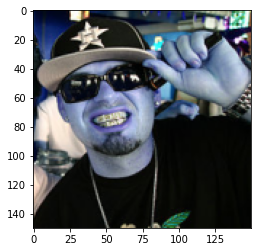

Detection Percent :  0.99989367
['word', 'cap', 'sunglasses', 'beard', 'hand', 'face', 'man', 'black', 'star']
Detection Percent :  0.27934995
['brick', 'wall', 'mural', 'painting', 'man', 'face', 'beard']
-----------------------


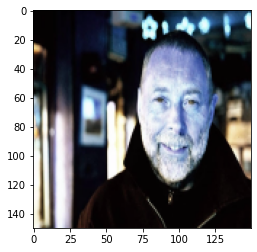

Detection Percent :  0.2412837
['logo', 'al', 'gore', 'cartoon', 'naked', 'man', 'fire', 'breath', 'frost', 'winter', 'snow', 'ice', 'bear', 'polar', 'animals']
Detection Percent :  0.9974843
['man', 'black', 'jacket', 'face', 'moustache', 'mustache', 'smile']
-----------------------


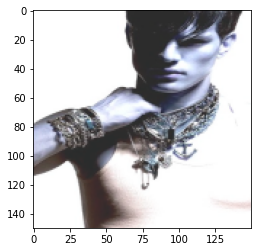

Detection Percent :  0.0003282023
['jewlery', 'anchor', 'bracelet', 'necklace', 'metal', 'man', 'face', 'shadow', 'white', 'dark']
Detection Percent :  0.008333931
['god', 'deity', 'old', 'man', 'painting', 'beard', 'white', 'grey', 'gray', 'religious', 'ear', 'profile', 'face']
-----------------------


In [ ]:
y_predict_0 = model.predict([X_image_test, X_tag_test_0])
y_predict_1 = model.predict([X_image_test, X_tag_test_1])
y_predict_arr_0 = np.array(y_predict_0)
y_predict_arr_1 = np.array(y_predict_1)

# Try on some random index value to check the image and scores for tags
vals = [30,55,100]

for idx in vals:
  plt.figure()
  plt.imshow(X_image_test[idx])
  plt.show()
  y_predict_0_idx = y_predict_arr_0[idx]
  y_predict_1_idx = y_predict_arr_1[idx]
  y_predict_0_idx, y_predict_1_idx


  word_tags_0 = test_image_label_df.iloc[idx]['word_tags_0']
  print("Detection Percent : ",*y_predict_0_idx)
  print(word_tags_0)
  word_tags_1 = test_image_label_df.iloc[idx]['word_tags_1']
  print("Detection Percent : ",*y_predict_1_idx)
  print(word_tags_1)

  print("-----------------------")

# 2 - Regression With UNET like Architecture

**Problem Statement**: House Price Prediction <br>
**Dataset**: Boston House Pricing Dataset Challenge. <br>
https://www.kaggle.com/c/gradient-boston-housing

The Boston data frame has 506 rows and 14 columns . The medv variable is the target variable. Given the different feature set we need to predict the prices of the house.



In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from keras.datasets import boston_housing
import tensorflow as tf 
from tensorflow.keras.layers import Dense,Dropout
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# Data Visualization

In [ ]:
pd.DataFrame(train_data).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65


# Data Pre-Processing
Normalization of the data is done by using standard normal formula.

In [ ]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std
pd.DataFrame(train_data).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.272246,-0.483615,-0.435762,-0.256833,-0.165227,-0.176443,0.813062,0.116698,-0.626249,-0.595170,1.148500,0.448077,0.825220
1,-0.403427,2.991784,-1.333912,-0.256833,-1.215182,1.894346,-1.910361,1.247585,-0.856463,-0.348433,-1.718189,0.431906,-1.329202
2,0.124940,-0.483615,1.028326,-0.256833,0.628642,-1.829688,1.110488,-1.187439,1.675886,1.565287,0.784476,0.220617,-1.308500
3,-0.401494,-0.483615,-0.869402,-0.256833,-0.361560,-0.324558,-1.236672,1.107180,-0.511142,-1.094663,0.784476,0.448077,-0.652926
4,-0.005634,-0.483615,1.028326,-0.256833,1.328612,0.153642,0.694808,-0.578572,1.675886,1.565287,0.784476,0.389882,0.263497


In [ ]:

lrelu = lambda x: tf.keras.layers.LeakyReLU(alpha=0.1)(x)

inp = tf.keras.Input(shape=(train_data.shape[1],))

fc1 = Dense(13, activation=lrelu,kernel_regularizer=tf.keras.regularizers.l2(0.1))(inp)
fc2 = Dense(8, activation=lrelu,kernel_regularizer=tf.keras.regularizers.l2(0.1))(fc1)
fc3 = Dense(4, activation=lrelu,kernel_regularizer=tf.keras.regularizers.l2(0.1))(fc2)

# Skip Connection 1
fc4 = Dense(4, activation=lrelu,kernel_regularizer=tf.keras.regularizers.l2(0.1))(fc3)
skip1 = tf.keras.layers.Add()([fc4, fc3])

# Skip Connection 2
fc5 = Dense(8, activation=lrelu,kernel_regularizer=tf.keras.regularizers.l2(0.1))(skip1)
skip2 = tf.keras.layers.Add()([fc5, fc2])

# Skip Connection 3
fc6 = Dense(13, activation=lrelu,kernel_regularizer=tf.keras.regularizers.l2(0.1))(skip2)
skip3 = tf.keras.layers.Add()([fc6,fc1])

output = Dense(1,activation=lrelu,kernel_regularizer=tf.keras.regularizers.l2(0.1))(skip3)
model = tf.keras.Model(inputs=inp,outputs=output)
model.build(input_shape=(train_data.shape[1],))
model.summary()

Model: "functional_44"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 13)]         0                                            
__________________________________________________________________________________________________
dense_169 (Dense)               (None, 13)           182         input_25[0][0]                   
__________________________________________________________________________________________________
dense_170 (Dense)               (None, 8)            112         dense_169[0][0]                  
__________________________________________________________________________________________________
dense_171 (Dense)               (None, 4)            36          dense_170[0][0]                  
______________________________________________________________________________________

In [ ]:
num_epochs = 150
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='mse',metrics=['mse'])
model.fit(train_data,train_targets,epochs=num_epochs,validation_data=(test_data, test_targets),batch_size=4,verbose=1)

Epoch 1/150
101/101 [==============================] - 0s 4ms/step - loss: 440.3951 - mse: 435.5174 - val_loss: 117.8390 - val_mse: 112.9740
Epoch 2/150
101/101 [==============================] - 0s 3ms/step - loss: 78.3251 - mse: 73.4699 - val_loss: 85.5243 - val_mse: 80.6791
Epoch 3/150
101/101 [==============================] - 0s 3ms/step - loss: 74.5666 - mse: 69.7308 - val_loss: 84.1288 - val_mse: 79.3037
Epoch 4/150
101/101 [==============================] - 0s 3ms/step - loss: 70.5640 - mse: 65.7466 - val_loss: 73.5337 - val_mse: 68.7255
Epoch 5/150
101/101 [==============================] - 0s 3ms/step - loss: 61.9759 - mse: 57.1758 - val_loss: 64.6985 - val_mse: 59.9044
Epoch 6/150
101/101 [==============================] - 0s 3ms/step - loss: 64.8329 - mse: 60.0461 - val_loss: 63.1258 - val_mse: 58.3470
Epoch 7/150
101/101 [==============================] - 0s 3ms/step - loss: 60.8564 - mse: 56.0818 - val_loss: 84.8454 - val_mse: 80.0764
Epoch 8/150
101/101 [================

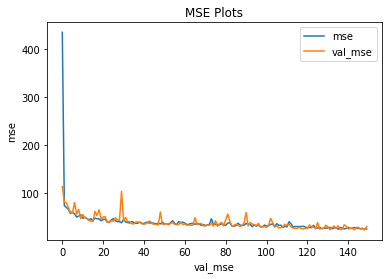

In [ ]:
plt.plot(model.history.history['mse'])
plt.plot(model.history.history['val_mse'])
plt.title('MSE Plots')
plt.ylabel('mse')
plt.xlabel('val_mse')
plt.legend(['mse', 'val_mse'])
plt.show()

# R2-Score

In [ ]:
from sklearn.metrics import r2_score
pred = model.predict(test_data)
score = r2_score(test_targets, pred)
print(score)


0.6411357619947475


# Comparison wrt Linear Regression from sklearn

In [ ]:
from sklearn.linear_model import LinearRegression 
regr = LinearRegression() 
regr.fit(train_data, train_targets) 
pred = regr.predict(test_data)
score = r2_score(test_targets, pred)
print(score)

0.7213535934621562


# 3 - ANN : Vanishing Gradient issue/Comparing Activation functions/regularization techniques 

**Dataset** : Admission dataset<br>
**Output** : chance of admission 

In [ ]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,ELU,PReLU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from sklearn.metrics import r2_score


## Loading Data

In [ ]:
data = pd.read_csv("Admission_Predict.csv")
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


## Dividing Independent and Dependent Variables

In [ ]:
y=data['Chance of Admit']
X=data.drop(['Chance of Admit'],axis=1)
X.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,1,337,118,4,4.5,4.5,9.65,1
1,2,324,107,4,4.0,4.5,8.87,1
2,3,316,104,3,3.0,3.5,8.00,1
3,4,322,110,3,3.5,2.5,8.67,1
4,5,314,103,2,2.0,3.0,8.21,0


## Data Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X=scaler.fit_transform(X)
X

array([[-1.72772608,  1.76210664,  1.74697064, ...,  1.16732114,
         1.76481828,  0.90911166],
       [-1.7190658 ,  0.62765641, -0.06763531, ...,  1.16732114,
         0.45515126,  0.90911166],
       [-1.71040552, -0.07046681, -0.56252785, ...,  0.05293342,
        -1.00563118,  0.90911166],
       ...,
       [ 1.71040552,  1.15124883,  1.41704229, ...,  1.16732114,
         1.42900622,  0.90911166],
       [ 1.7190658 , -0.41952842, -0.72749202, ...,  0.61012728,
         0.30403584, -1.09997489],
       [ 1.72772608,  1.41304503,  1.58200646, ...,  0.61012728,
         1.78160888,  0.90911166]])

## Train Test Split 70 : 30 ratio

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

## Model Architecture

Input Layer neurons: 50<br> 
2nd Layer neurons: 25<br>
3rd Layer neurons: 5<br>
Output Layer neurons: 1

## Comparing optimizers

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 50)                450       
_________________________________________________________________
dense_85 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_86 (Dense)             (None, 5)                 130       
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 6         
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
_________________________________________________________________


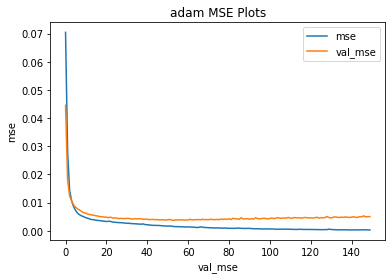

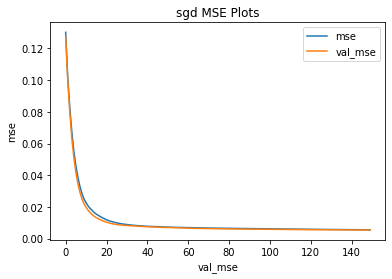

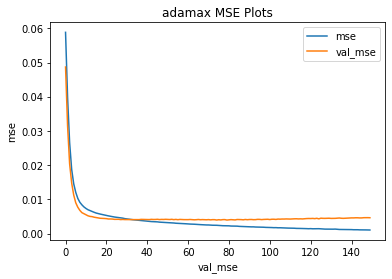

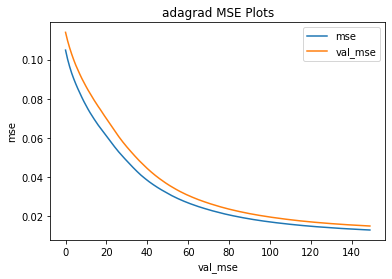

In [ ]:
scores={}
for i in ['adam','sgd','adamax','adagrad']:
    # create a null or empty ANN
    classifier=Sequential()

    #Add input layer
    classifier.add(Dense(units=50,kernel_initializer='he_uniform',activation='relu',input_dim=8))

    #Add hidden layer
    classifier.add(Dense(units=25,kernel_initializer='he_uniform',activation='relu'))
    
    #Add hidden layer
    classifier.add(Dense(units=5,kernel_initializer='he_uniform',activation='relu'))

    #Add output layer
    classifier.add(Dense(units=1,activation='sigmoid'))

    #print created ANN
    if i=='adam':
        classifier.summary()

    #compiling ANN
    classifier.compile(optimizer= i ,loss='mse',metrics=['mse'])

    #fiiting ANN to training data
    model=classifier.fit(x_train,y_train,validation_split=0.33,batch_size=10,epochs=150,verbose=0)

    plt.plot(model.history['mse'])
    plt.plot(model.history['val_mse'])
    plt.title(i+' MSE Plots')
    plt.ylabel('mse')
    plt.xlabel('val_mse')
    plt.legend(['mse', 'val_mse'])
    plt.show()

    pred = classifier.predict(x_test)
    score = r2_score(y_test, pred)
    scores[i]=score

### R2 Scores for different Optimizers

In [ ]:
print('Activation function\t','R2 Score')
for i in ['adam','sgd','adamax','adagrad']:
        print(i,end='')
        print('\t\t',scores[i])

Activation function	 R2 Score
adam		 0.7010788216011158
sgd		 0.7365051232309747
adamax		 0.8123486840665222
adagrad		 0.3034622212686273


## Comparing different Activation functions

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 50)                450       
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 50)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 25)                1275      
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 25)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 5)                 130       
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 5)                 0         
_________________________________________________________________
dense_103 (Dense)            (None, 1)               

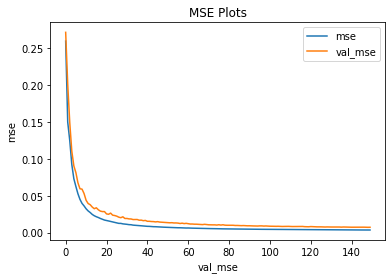

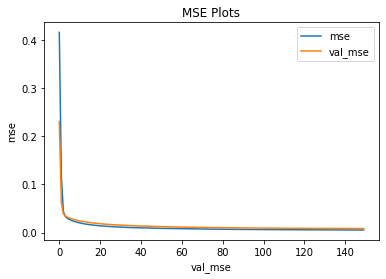

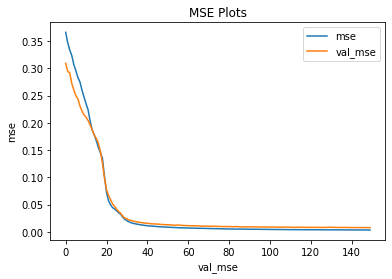

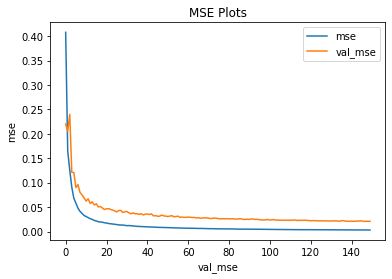

In [ ]:
scores={}
for i in ['adam','sgd','adamax','adagrad']:

    # create a null or empty ANN
    classifier=Sequential()

    #Add input layer
    classifier.add(Dense(units=50,kernel_initializer='he_uniform',input_dim=8))
    classifier.add(LeakyReLU(alpha=0.05))

    #Add hidden layer
    classifier.add(Dense(units=25,kernel_initializer='he_uniform'))
    classifier.add(LeakyReLU(alpha=0.05))

    #Add hidden layer
    classifier.add(Dense(units=5,kernel_initializer='he_uniform'))
    classifier.add(LeakyReLU(alpha=0.05))

    #Add output layer
    classifier.add(Dense(units=1,activation='relu'))

    #print created ANN
    if i=='adam':
        classifier.summary()

    #compiling ANN
    classifier.compile(optimizer='sgd',loss='mse',metrics=['mse'])

    #fiiting ANN to training data
    model=classifier.fit(x_train,y_train,validation_split=0.33,batch_size=10,epochs=150,verbose=0)


    plt.plot(model.history['mse'])
    plt.plot(model.history['val_mse'])
    plt.title('MSE Plots')
    plt.ylabel('mse')
    plt.xlabel('val_mse')
    plt.legend(['mse', 'val_mse'])
    plt.show()

    pred = classifier.predict(x_test)
    score = r2_score(y_test, pred)
    scores[i]=score

### R2 Scores for different Activation functions

In [ ]:
print('Activation function\t','R2 Score')
for i in ['adam','sgd','adamax','adagrad']:
        print(i,end='')
        print('\t\t',scores[i])

Activation function	 R2 Score
adam		 0.6936836259314767
sgd		 0.534467985063638
adamax		 0.44811645334799743
adagrad		 0.20202250850387815


## Adding Dropout layer for regularization

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 50)                450       
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 50)                0         
_________________________________________________________________
dense_117 (Dense)            (None, 25)                1275      
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 25)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_118 (Dense)            (None, 5)                 130       
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 5)               

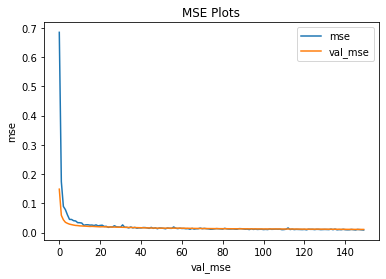

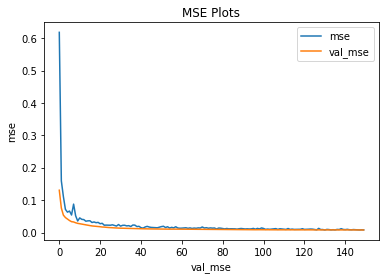

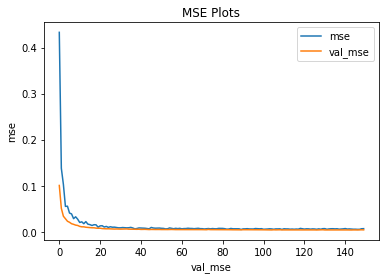

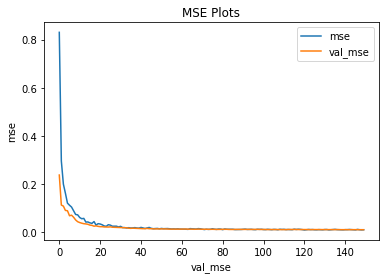

In [ ]:
scores={}
for i in ['adam','sgd','adamax','adagrad']:

    # create a null or empty ANN
    classifier=Sequential()

    #Add input layer
    classifier.add(Dense(units=50,kernel_initializer='he_uniform',input_dim=8))
    classifier.add(LeakyReLU(alpha=0.05))

    #Add hidden layer
    classifier.add(Dense(units=25,kernel_initializer='he_uniform'))
    classifier.add(LeakyReLU(alpha=0.05))
    classifier.add(Dropout(0.3))

    #Add hidden layer
    classifier.add(Dense(units=5,kernel_initializer='he_uniform'))
    classifier.add(LeakyReLU(alpha=0.05))

    #Add output layer
    classifier.add(Dense(units=1,))

    #print created ANN
    if i=='adam':
        classifier.summary()

    #compiling ANN
    classifier.compile(optimizer='sgd',loss='mse',metrics=['mse'])

    #fiiting ANN to training data
    model=classifier.fit(x_train,y_train,validation_split=0.33,batch_size=10,epochs=150,verbose=0)


    plt.plot(model.history['mse'])
    plt.plot(model.history['val_mse'])
    plt.title('MSE Plots')
    plt.ylabel('mse')
    plt.xlabel('val_mse')
    plt.legend(['mse', 'val_mse'])
    plt.show()

    pred = classifier.predict(x_test)
    score = r2_score(y_test, pred)
    scores[i]=score

### R2 scores after adding dropout layer

In [ ]:
print('Activation function\t','R2 Score')
for i in ['adam','sgd','adamax','adagrad']:
        print(i,end='')
        print('\t\t',scores[i])

Activation function	 R2 Score
adam		 0.5286741729404816
sgd		 0.5972679907658298
adamax		 0.7596016200210205
adagrad		 0.5440601014758368


## Adding Batch Normalization for regularization

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_132 (Dense)            (None, 50)                450       
_________________________________________________________________
leaky_re_lu_63 (LeakyReLU)   (None, 50)                0         
_________________________________________________________________
dense_133 (Dense)            (None, 25)                1275      
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 25)                0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 25)                100       
_________________________________________________________________
dense_134 (Dense)            (None, 5)                 130       
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 5)               

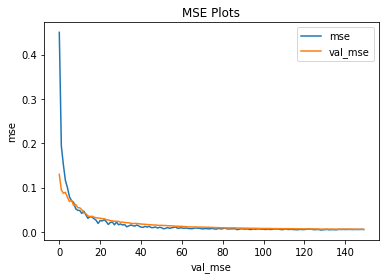

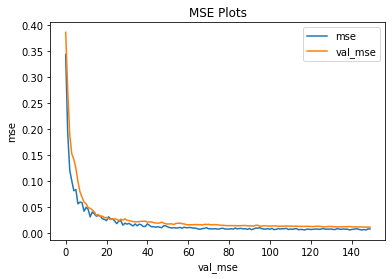

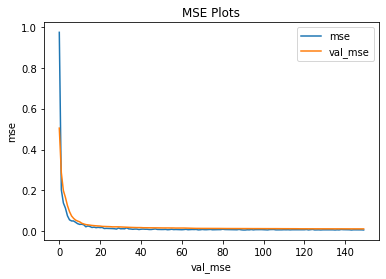

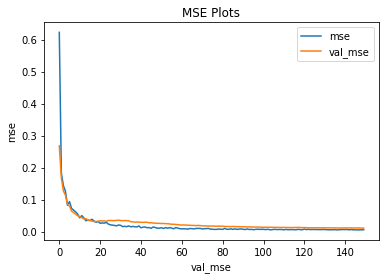

In [ ]:
scores={}
for i in ['adam','sgd','adamax','adagrad']:

    # create a null or empty ANN
    classifier=Sequential()

    #Add input layer
    classifier.add(Dense(units=50,kernel_initializer='he_uniform',input_dim=8))
    classifier.add(LeakyReLU(alpha=0.05))

    #Add hidden layer
    classifier.add(Dense(units=25,kernel_initializer='he_uniform'))
    classifier.add(LeakyReLU(alpha=0.05))
    classifier.add(BatchNormalization())

    #Add hidden layer
    classifier.add(Dense(units=5,kernel_initializer='he_uniform'))
    classifier.add(LeakyReLU(alpha=0.05))

    #Add output layer
    classifier.add(Dense(units=1,))

    #print created ANN
    if i=='adam':
        classifier.summary()

    #compiling ANN
    classifier.compile(optimizer='sgd',loss='mse',metrics=['mse'])

    #fiiting ANN to training data
    model=classifier.fit(x_train,y_train,validation_split=0.33,batch_size=10,epochs=150,verbose=0)


    plt.plot(model.history['mse'])
    plt.plot(model.history['val_mse'])
    plt.title('MSE Plots')
    plt.ylabel('mse')
    plt.xlabel('val_mse')
    plt.legend(['mse', 'val_mse'])
    plt.show()

    pred = classifier.predict(x_test)
    score = r2_score(y_test, pred)
    scores[i]=score

### R2 Scores after adding Batch Normalization

In [ ]:
print('Activation function\t','R2 Score')
for i in ['adam','sgd','adamax','adagrad']:
        print(i,end='')
        print('\t\t',scores[i])

Activation function	 R2 Score
adam		 0.6483268923909812
sgd		 0.6402239120981814
adamax		 0.6642671140902177
adagrad		 0.7450852001855938


# The End